In [1]:
import pandas as pd
import numpy as np
import json
import sys
from sklearn.preprocessing import LabelEncoder   #把字串符號轉數字
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from matplotlib import pyplot as plt
import math

In [2]:
label = pd.read_csv("SMP/train_label.txt", header = None) #處理沒有feature name的方式
label = label.rename(columns={0:'score'})
label.head()

,score
0,11.18
1,15.15
2,10.99
3,8.63
4,11.16


In [3]:
with open('SMP/train_tags.json', 'r') as f:
    tags = json.load(f)
tags = pd.DataFrame(tags)
#tags.head()

In [4]:
AllTags = []
for i in range(len(tags['Alltags'])):
    AllTags.append(len(tags['Alltags'][i].split()))

AllTags = pd.DataFrame(AllTags)
AllTags = AllTags.rename(columns={0:'TagsCount'})
AllTags.head()

,TagsCount
0,12
1,65
2,23
3,9
4,19


In [5]:
with open('SMP/train_temporalspatial.json', 'r') as ff:
    temporalspatial = json.load(ff)
temporalspatial = pd.DataFrame(temporalspatial)
#temporalspatial.head()

In [6]:
postDate = temporalspatial[["Uid","Pid","Postdate"]]
postDate = pd.DataFrame(postDate)
postDate.head()

,Uid,Pid,Postdate
0,59@N75,775,1446016778
1,1@N18,1075,1454983379
2,351@N64,4890,1433118604
3,6@N59,6568,1451577600
4,1617@N40,7079,1425744438


In [7]:
with open('SMP/train_category.json', 'r') as ff:
    category = json.load(ff)
category = pd.DataFrame(category)

In [8]:
category = category[["Category", "Subcategory", "Concept"]]
category = pd.DataFrame(category)
category.head()

,Category,Subcategory,Concept
0,Fashion,Fashion,glam
1,Travel&Active&Sports,Soccer,fifa
2,Entertainment,Movies,cinema
3,Holiday&Celebrations,Birthday,old
4,Food,Drinks,thirsty


In [9]:
trainData = pd.concat( [postDate, category], axis=1 )
trainData = pd.concat( [trainData, AllTags], axis=1 )
trainData = pd.concat( [trainData, label], axis=1 )

In [10]:
trainData.head()

,Uid,Pid,Postdate,Category,Subcategory,Concept,TagsCount,score
0,59@N75,775,1446016778,Fashion,Fashion,glam,12,11.18
1,1@N18,1075,1454983379,Travel&Active&Sports,Soccer,fifa,65,15.15
2,351@N64,4890,1433118604,Entertainment,Movies,cinema,23,10.99
3,6@N59,6568,1451577600,Holiday&Celebrations,Birthday,old,9,8.63
4,1617@N40,7079,1425744438,Food,Drinks,thirsty,19,11.16


In [11]:
#trainData.isnull().any()

In [12]:
with open('SMP/train_img.txt', 'r') as f:
    imgs = f.read().splitlines()

In [13]:
imageID = []
for i in range(len(imgs)):
    imageID.append(imgs[i].split('/')[-1])
imageID = pd.DataFrame(imageID)
imageID = imageID.rename(columns={0:'imageID'})
imageID.head()

,imageID
0,385070026
1,943750056
2,3246928439
3,3432316502
4,3538960847


In [14]:
trainData = pd.concat([imageID, trainData], axis=1)
trainData.head()

,imageID,Uid,Pid,Postdate,Category,Subcategory,Concept,TagsCount,score
0,385070026,59@N75,775,1446016778,Fashion,Fashion,glam,12,11.18
1,943750056,1@N18,1075,1454983379,Travel&Active&Sports,Soccer,fifa,65,15.15
2,3246928439,351@N64,4890,1433118604,Entertainment,Movies,cinema,23,10.99
3,3432316502,6@N59,6568,1451577600,Holiday&Celebrations,Birthday,old,9,8.63
4,3538960847,1617@N40,7079,1425744438,Food,Drinks,thirsty,19,11.16


In [15]:
with open('SMP/image_object.txt', 'r') as f:
    object = f.read().splitlines()
len(object[0].split(','))

imageID = []
for i in range(len(object)):
    imageID.append(object[i].split(',')[0])
imageID = pd.DataFrame(imageID)
imageID = imageID.rename(columns={0:'imageID'})
imageID.head()

AllObject = []
for i in range(len(object)):
    AllObject.append(len(object[i].split(','))-2)
AllObject = pd.DataFrame(AllObject)
AllObject = AllObject.rename(columns={0:'AllObject'})
AllObject.head()

trainObject = pd.concat( [imageID , AllObject], axis=1 )

trainObject.head()

,imageID,AllObject
0,10033402254,4
1,10074972466,2
2,10119284375,2
3,10137707764,0
4,10138499783,1


In [16]:
trainData = pd.merge(trainObject, trainData, how='left', on='imageID')
trainData.head()

,imageID,AllObject,Uid,Pid,Postdate,Category,Subcategory,Concept,TagsCount,score
0,10033402254,4,4352@N69,84284,1437117157,Urban,Architecture,abstract,58,9.87
1,10074972466,2,5392@N53,84460,1433865600,Family,Babies,cuddly,27,10.56
2,10119284375,2,11830@N28,84623,1431863504,Urban,Architecture,perspective,25,10.52
3,10137707764,0,11830@N28,84758,1429013791,Urban,Architecture,perspective,33,10.14
4,10138499783,1,11830@N28,84760,1425808471,Urban,Architecture,perspective,19,11.70


In [17]:
trainData = trainData.drop(['imageID'], axis=1)
#trainData.columns
trainData = trainData[['Uid', 'Pid', 'Postdate', 'Category', 'Subcategory','Concept', 'TagsCount', 'AllObject', 'score']]
trainData.head()

,Uid,Pid,Postdate,Category,Subcategory,Concept,TagsCount,AllObject,score
0,4352@N69,84284,1437117157,Urban,Architecture,abstract,58,4,9.87
1,5392@N53,84460,1433865600,Family,Babies,cuddly,27,2,10.56
2,11830@N28,84623,1431863504,Urban,Architecture,perspective,25,2,10.52
3,11830@N28,84758,1429013791,Urban,Architecture,perspective,33,0,10.14
4,11830@N28,84760,1425808471,Urban,Architecture,perspective,19,1,11.70


In [18]:
trainData["Uid"] = trainData["Uid"].apply(str)
trainData["Uid"] = LabelEncoder().fit_transform(trainData["Uid"])
trainData["Category"] = trainData["Category"].apply(str)
trainData["Category"] = LabelEncoder().fit_transform(trainData["Category"])
trainData["Subcategory"] = trainData["Subcategory"].apply(str)
trainData["Subcategory"] = LabelEncoder().fit_transform(trainData["Subcategory"])
trainData["Concept"] = trainData["Concept"].apply(str)
trainData["Concept"] = LabelEncoder().fit_transform(trainData["Concept"])

trainData["Pid"] = trainData["Pid"].apply(int)
trainData["Postdate"] = trainData["Postdate"].apply(int)

trainData.head()

,Uid,Pid,Postdate,Category,Subcategory,Concept,TagsCount,AllObject,score
0,19987,84284,1437117157,9,0,0,58,4,9.87
1,27201,84460,1433865600,3,1,139,27,2,10.56
2,1002,84623,1431863504,9,0,442,25,2,10.52
3,1002,84758,1429013791,9,0,442,33,0,10.14
4,1002,84760,1425808471,9,0,442,19,1,11.70


In [19]:
temp , X_test= train_test_split(trainData, test_size=0.2)
X_train , X_valid = train_test_split(temp,test_size=0.1)
Y_train = X_train["score"]
X_train = X_train.drop(["score"],axis = 1)
Y_test = X_test["score"]
X_test = X_test.drop(["score"],axis = 1)
Y_valid = X_valid["score"]
X_valid = X_valid.drop(["score"],axis = 1)

In [20]:
model = XGBRegressor(
    max_depth=9,
    n_estimators=1000,
    min_child_weight=1, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 15)

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:5.80681	validation_1-rmse:5.83563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:5.29491	validation_1-rmse:5.32205
[2]	validation_0-rmse:4.83786	validation_1-rmse:4.86368
[3]	validation_0-rmse:4.43196	validation_1-rmse:4.45642
[4]	validation_0-rmse:4.07417	validation_1-rmse:4.09797
[5]	validation_0-rmse:3.76223	validation_1-rmse:3.78574
[6]	validation_0-rmse:3.48103	validation_1-rmse:3.50381
[7]	validation_0-rmse:3.23542	validation_1-rmse:3.25805
[8]	validation_0-rmse:3.01871	validation_1-rmse:3.04213
[9]	validation_0-rmse:2.82877	validation_1-rmse:2.85272
[10]	validation_0-rmse:2.66629	validation_1-rmse:2.69014
[11]	validation_0-rmse:2.52123	validation_1-rmse:2.54539
[12]	validation_0-rmse:2.39629	validation_1-rmse:2.42105
[13]	validation_0-rmse:2.28974	validation_1-rmse:2.31531
[14]	validation_0-rmse:2.196	validation_1-rmse:2.2225

[141]	validation_0-rmse:1.29685	validation_1-rmse:1.41854
[142]	validation_0-rmse:1.29513	validation_1-rmse:1.4174
[143]	validation_0-rmse:1.29352	validation_1-rmse:1.4166
[144]	validation_0-rmse:1.29144	validation_1-rmse:1.41524
[145]	validation_0-rmse:1.29006	validation_1-rmse:1.41465
[146]	validation_0-rmse:1.28868	validation_1-rmse:1.41361
[147]	validation_0-rmse:1.28736	validation_1-rmse:1.41281
[148]	validation_0-rmse:1.28594	validation_1-rmse:1.41192
[149]	validation_0-rmse:1.28455	validation_1-rmse:1.41145
[150]	validation_0-rmse:1.28383	validation_1-rmse:1.41094
[151]	validation_0-rmse:1.28292	validation_1-rmse:1.41017
[152]	validation_0-rmse:1.28081	validation_1-rmse:1.40879
[153]	validation_0-rmse:1.27856	validation_1-rmse:1.40727
[154]	validation_0-rmse:1.27551	validation_1-rmse:1.40468
[155]	validation_0-rmse:1.27383	validation_1-rmse:1.40348
[156]	validation_0-rmse:1.27065	validation_1-rmse:1.40148
[157]	validation_0-rmse:1.26994	validation_1-rmse:1.40111
[158]	validation

[283]	validation_0-rmse:1.12088	validation_1-rmse:1.3158
[284]	validation_0-rmse:1.12038	validation_1-rmse:1.3156
[285]	validation_0-rmse:1.11946	validation_1-rmse:1.31504
[286]	validation_0-rmse:1.11865	validation_1-rmse:1.31482
[287]	validation_0-rmse:1.11762	validation_1-rmse:1.31439
[288]	validation_0-rmse:1.11676	validation_1-rmse:1.314
[289]	validation_0-rmse:1.11504	validation_1-rmse:1.31326
[290]	validation_0-rmse:1.11386	validation_1-rmse:1.31297
[291]	validation_0-rmse:1.11315	validation_1-rmse:1.31262
[292]	validation_0-rmse:1.11301	validation_1-rmse:1.31257
[293]	validation_0-rmse:1.11191	validation_1-rmse:1.31203
[294]	validation_0-rmse:1.11056	validation_1-rmse:1.31148
[295]	validation_0-rmse:1.10966	validation_1-rmse:1.31098
[296]	validation_0-rmse:1.10928	validation_1-rmse:1.31087
[297]	validation_0-rmse:1.10899	validation_1-rmse:1.3108
[298]	validation_0-rmse:1.10803	validation_1-rmse:1.31034
[299]	validation_0-rmse:1.1068	validation_1-rmse:1.30965
[300]	validation_0-r

[425]	validation_0-rmse:1.00461	validation_1-rmse:1.26033
[426]	validation_0-rmse:1.00352	validation_1-rmse:1.25998
[427]	validation_0-rmse:1.00331	validation_1-rmse:1.25991
[428]	validation_0-rmse:1.00236	validation_1-rmse:1.25951
[429]	validation_0-rmse:1.00215	validation_1-rmse:1.25945
[430]	validation_0-rmse:1.00185	validation_1-rmse:1.25941
[431]	validation_0-rmse:1.00143	validation_1-rmse:1.25933
[432]	validation_0-rmse:0.9999	validation_1-rmse:1.25872
[433]	validation_0-rmse:0.999128	validation_1-rmse:1.25827
[434]	validation_0-rmse:0.998824	validation_1-rmse:1.25816
[435]	validation_0-rmse:0.997986	validation_1-rmse:1.25789
[436]	validation_0-rmse:0.997262	validation_1-rmse:1.25751
[437]	validation_0-rmse:0.99574	validation_1-rmse:1.25681
[438]	validation_0-rmse:0.995098	validation_1-rmse:1.25656
[439]	validation_0-rmse:0.994602	validation_1-rmse:1.25628
[440]	validation_0-rmse:0.993892	validation_1-rmse:1.25616
[441]	validation_0-rmse:0.993069	validation_1-rmse:1.25563
[442]	v

[565]	validation_0-rmse:0.924502	validation_1-rmse:1.22958
[566]	validation_0-rmse:0.924107	validation_1-rmse:1.22946
[567]	validation_0-rmse:0.92346	validation_1-rmse:1.22921
[568]	validation_0-rmse:0.923428	validation_1-rmse:1.22922
[569]	validation_0-rmse:0.922619	validation_1-rmse:1.22894
[570]	validation_0-rmse:0.922408	validation_1-rmse:1.22891
[571]	validation_0-rmse:0.921678	validation_1-rmse:1.22866
[572]	validation_0-rmse:0.921063	validation_1-rmse:1.22833
[573]	validation_0-rmse:0.920836	validation_1-rmse:1.2283
[574]	validation_0-rmse:0.92051	validation_1-rmse:1.22817
[575]	validation_0-rmse:0.920197	validation_1-rmse:1.22808
[576]	validation_0-rmse:0.919721	validation_1-rmse:1.22796
[577]	validation_0-rmse:0.919124	validation_1-rmse:1.22772
[578]	validation_0-rmse:0.91864	validation_1-rmse:1.22769
[579]	validation_0-rmse:0.917983	validation_1-rmse:1.22732
[580]	validation_0-rmse:0.917465	validation_1-rmse:1.22723
[581]	validation_0-rmse:0.91711	validation_1-rmse:1.22694
[5

[705]	validation_0-rmse:0.854467	validation_1-rmse:1.20478
[706]	validation_0-rmse:0.853651	validation_1-rmse:1.20435
[707]	validation_0-rmse:0.853392	validation_1-rmse:1.20428
[708]	validation_0-rmse:0.852572	validation_1-rmse:1.20419
[709]	validation_0-rmse:0.852159	validation_1-rmse:1.20413
[710]	validation_0-rmse:0.851083	validation_1-rmse:1.2036
[711]	validation_0-rmse:0.850831	validation_1-rmse:1.20348
[712]	validation_0-rmse:0.850062	validation_1-rmse:1.20312
[713]	validation_0-rmse:0.84926	validation_1-rmse:1.20305
[714]	validation_0-rmse:0.848809	validation_1-rmse:1.20279
[715]	validation_0-rmse:0.84791	validation_1-rmse:1.20233
[716]	validation_0-rmse:0.847634	validation_1-rmse:1.20216
[717]	validation_0-rmse:0.847281	validation_1-rmse:1.20213
[718]	validation_0-rmse:0.846862	validation_1-rmse:1.20199
[719]	validation_0-rmse:0.846508	validation_1-rmse:1.20193
[720]	validation_0-rmse:0.846211	validation_1-rmse:1.20196
[721]	validation_0-rmse:0.845656	validation_1-rmse:1.20189


[845]	validation_0-rmse:0.794226	validation_1-rmse:1.1856
[846]	validation_0-rmse:0.794024	validation_1-rmse:1.18557
[847]	validation_0-rmse:0.793755	validation_1-rmse:1.18543
[848]	validation_0-rmse:0.793258	validation_1-rmse:1.18506
[849]	validation_0-rmse:0.792867	validation_1-rmse:1.18501
[850]	validation_0-rmse:0.792421	validation_1-rmse:1.18491
[851]	validation_0-rmse:0.792249	validation_1-rmse:1.18479
[852]	validation_0-rmse:0.791832	validation_1-rmse:1.18466
[853]	validation_0-rmse:0.791336	validation_1-rmse:1.18464
[854]	validation_0-rmse:0.790925	validation_1-rmse:1.1845
[855]	validation_0-rmse:0.790787	validation_1-rmse:1.18447
[856]	validation_0-rmse:0.790354	validation_1-rmse:1.18417
[857]	validation_0-rmse:0.789743	validation_1-rmse:1.18407
[858]	validation_0-rmse:0.789258	validation_1-rmse:1.18406
[859]	validation_0-rmse:0.788992	validation_1-rmse:1.18398
[860]	validation_0-rmse:0.788636	validation_1-rmse:1.18395
[861]	validation_0-rmse:0.788202	validation_1-rmse:1.18377

[985]	validation_0-rmse:0.744942	validation_1-rmse:1.17153
[986]	validation_0-rmse:0.74455	validation_1-rmse:1.17135
[987]	validation_0-rmse:0.744331	validation_1-rmse:1.17127
[988]	validation_0-rmse:0.744052	validation_1-rmse:1.1712
[989]	validation_0-rmse:0.743745	validation_1-rmse:1.17103
[990]	validation_0-rmse:0.74341	validation_1-rmse:1.17092
[991]	validation_0-rmse:0.743053	validation_1-rmse:1.17088
[992]	validation_0-rmse:0.742515	validation_1-rmse:1.17078
[993]	validation_0-rmse:0.742228	validation_1-rmse:1.17064
[994]	validation_0-rmse:0.741623	validation_1-rmse:1.17039
[995]	validation_0-rmse:0.741405	validation_1-rmse:1.1704
[996]	validation_0-rmse:0.741015	validation_1-rmse:1.1703
[997]	validation_0-rmse:0.740696	validation_1-rmse:1.17016
[998]	validation_0-rmse:0.740132	validation_1-rmse:1.17011
[999]	validation_0-rmse:0.739849	validation_1-rmse:1.17001


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

In [21]:
Y_pred = model.predict(X_test).clip(0, 20)
print(Y_pred)

[6.9078693 7.3323646 5.121147  ... 5.5810537 4.4653263 5.163942 ]


In [22]:
error = []
for i in range(len(Y_test)):
    error.append(Y_test.values[i] - Y_pred[i])
    
#print("Errors: ", error)
#print(error)
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)#平方
    absError.append(abs(val))#誤差絕對值
    
#print("Square Error: ", squaredError)
#print("Absolute Value of Error: ", absError)
print("MSE = ", sum(squaredError) / len(squaredError))#平均平方誤差MSE


#from math import sqrt
#print("RMSE = ", sqrt(sum(squaredError) / len(squaredError)))#平均平方根誤差RMSE
print("MAE = ", sum(absError) / len(absError))#平均絕對誤差MAE

MSE =  1.3637046271981277
MAE =  0.7225075263135314


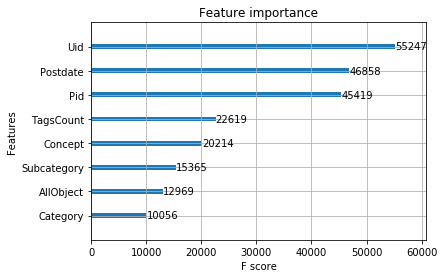

In [23]:
plot_importance(model)
plt.show()